In [1]:
# Import Libraries 
import cv2
import numpy as np
from plantcv import plantcv as pcv
import matplotlib.pyplot as plt



In [2]:
class options:
    def __init__(self):
        self.image = "Still-1-Camera_Name-2021-06-13_11-27-57.jpg"
        self.debug = "plot"
        self.writeimg= False 
        self.result = "vis_nir_test_results.json"
        self.outdir = "." # Store the output to the current directory

# Get options
args = options()

# Set debug to the global parameter 
pcv.params.debug = args.debug

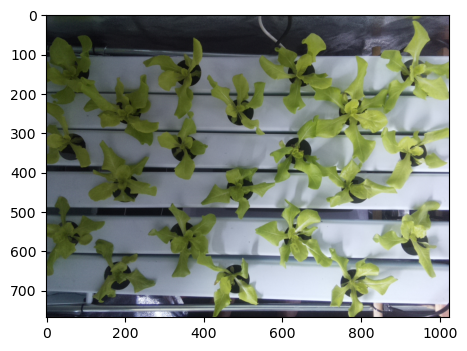

In [8]:
# Read image 

# Inputs:
#   filename - Image file to be read in 
#   mode - Return mode of image; either 'native' (default), 'rgb', 'gray', or 'csv' 
img, path, filename = pcv.readimage(filename=args.image)


In [4]:
# Check if this is a night image, for some of these dataset's images were captured
# at night, even if nothing is visible. To make sure that images are not taken at
# night we check that the image isn't mostly dark (0=black, 255=white).
# if it is a night image it throws a fatal error and stops the workflow.

if np.average(img) < 50:
    pcv.fatal_error("Night Image")
else:
    pass

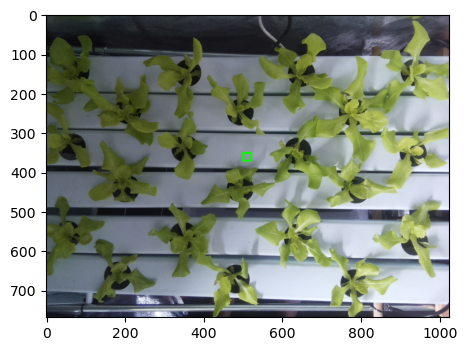

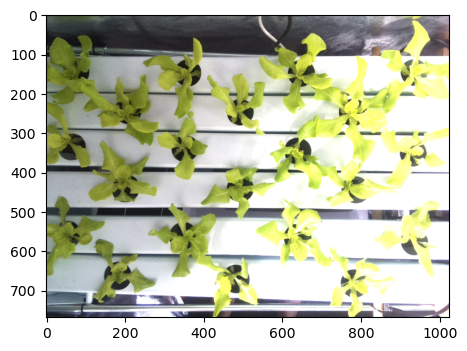

In [5]:
# Normalize the white color so you can later
# compare color between images.

# Inputs:
#   img = image object, RGB color space
#   roi = region for white reference, if none uses the whole image,
#         otherwise (x position, y position, box width, box height)

# white balance image based on white toughspot
img1 = pcv.white_balance(img, roi=(500,350,20,20))

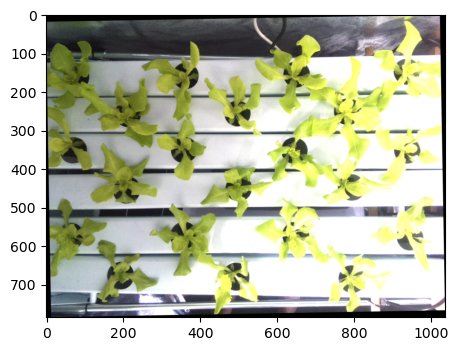

In [6]:
# Rotate the image slightly so the plants line up with 
# the grid that we'll add in a later step

# Inputs:
#   img = image object, RGB color space
#   rotation_deg = Rotation angle in degrees, can be negative, positive values 
#                  will move counter-clockwise 
#   crop = If True then image will be cropped to orginal image dimensions, if False
#          the image size will be adjusted to accommodate new image dimensions 
rotate_img = pcv.rotate(img=img1, rotation_deg=1, crop=False)



In [7]:
# Shift image. This step is important for clustering later on.
# For this image it also allows you to push the green raspberry pi camera
# out of the image. This step might not be necessary for all images.
# The resulting image is the same size as the original.

# Inputs:
#   img    = image object
#   number = integer, number of pixels to move image
#   side   = direction to move from "top", "bottom", "right","left"
# shift1 = pcv.shift_img(img=img1, number=100, side='bottom')
#img1 = shift1

In [227]:
# Create float
bgr = img1.astype(float)/255.

In [228]:
# Extract channels
with np.errstate(invalid='ignore', divide='ignore'):
	K = 1 - np.max(bgr, axis=2)
	C = (1-bgr[...,2] - K)/(1-K)
	M = (1-bgr[...,1] - K)/(1-K)
	Y = (1-bgr[...,0] - K)/(1-K)

In [229]:
# Convert the input BGR image to CMYK colorspace
CMYK = (np.dstack((C,M,Y,K)) * 255).astype(np.uint8)

# Split CMYK channels
Y, M, C, K = cv2.split(CMYK)

np.isfinite(C).all()
np.isfinite(M).all()
np.isfinite(K).all()
np.isfinite(Y).all()

True

In [230]:
# Save channels
#cv2.imwrite('C.jpg', C)
#cv2.imwrite('M.jpg', M)
#cv2.imwrite('Y.jpg', Y)
#cv2.imwrite('K.jpg', K)

In [231]:
#img2 = pcv.readimage(filename='C.jpg')

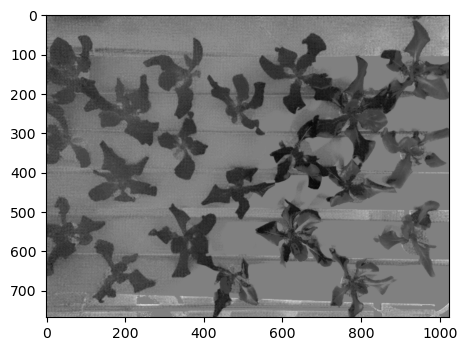

In [232]:
# Convert image from RGB color space to LAB color space
# Keep only the green-magenta channel (grayscale)

# Inputs:
#    rgb_img = image object, RGB color space
#    channel = color subchannel ('l' = lightness, 'a' = green-magenta , 'b' = blue-yellow)
a = pcv.rgb2gray_lab(rgb_img=img1, channel='a')

# image converted from RGB to HSV, channels are then split. 
# Hue ('h') channel is output
#h_channel = pcv.rgb2gray_hsv(rgb_img=img1, channel='h')

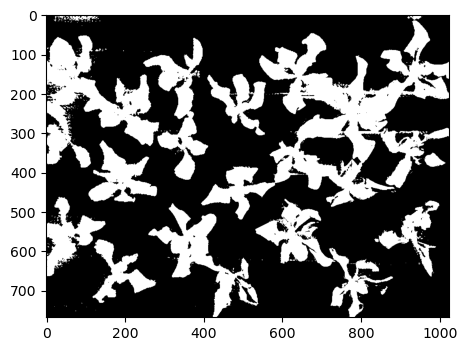

In [233]:
# Set a binary threshold on the saturation channel image

# Inputs:
#    gray_img    = img object, grayscale
#    threshold   = threshold value (0-255)
#    max_value   = value to apply above threshold (usually 255 = white)
#    object_type = light or dark
#       - If object is light then standard thresholding is done
#       - If object is dark then inverse thresholding is done
img_binary = pcv.threshold.binary(gray_img=a, threshold=118, max_value=255, object_type='dark')
#                                                        ^
#                                                        |
#                                         adjust this value

#img_binary1 = pcv.threshold.binary(gray_img=C, threshold=80, max_value=255, object_type='light')
#img_binary2 = pcv.threshold.binary(gray_img=C, threshold=205, max_value=255, object_type='dark')


In [234]:
# Combine two images that have had different thresholds applied to them.
# For logical 'and' operation object pixel must be in both images 
# to be included in 'and' image.
#and_image = pcv.logical_and(img_binary1, img_binary2)

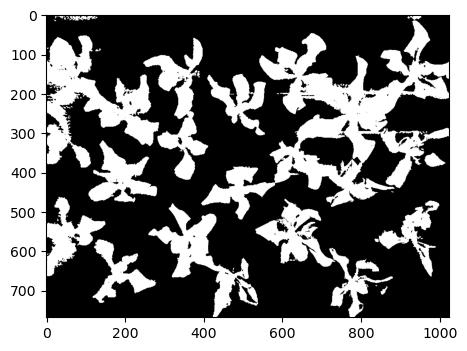

In [235]:
# Fill in small objects (speckles)

# Inputs:
#    bin_img  = binary image. img will be returned after filling
#    size     = minimum object area size in pixels (integer)
fill_image = pcv.fill(bin_img=img_binary, size=10)
#                                                ^
#                                                |
#                                 adjust this value

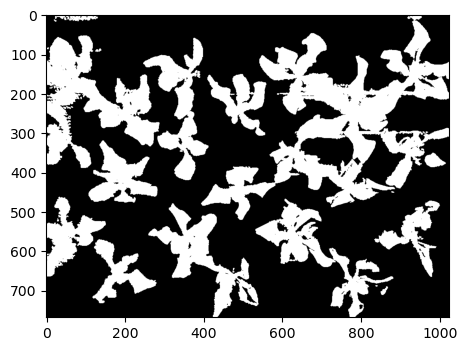

In [236]:
# Dilate so that you don't lose leaves (just in case)

# Inputs:
#    gray_img = input image
#    ksize    = integer, kernel size
#    i        = iterations, i.e. number of consecutive filtering passes
dilated = pcv.dilate(gray_img=fill_image, ksize=2, i=1)

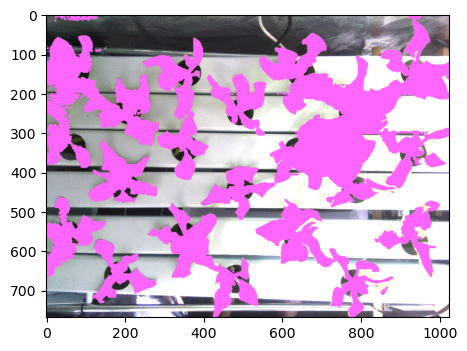

In [237]:
# Find objects (contours: black-white boundaries)

# Inputs:
#    img  = image that the objects will be overlayed
#    mask = what is used for object detection
id_objects, obj_hierarchy = pcv.find_objects(img=img1, mask=dilated)

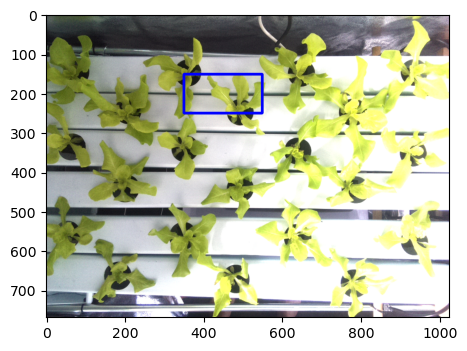

In [240]:
# Define region of interest (ROI)

# Inputs:
#    img   = An RGB or grayscale image to plot the ROI on.
#    x     = The x-coordinate of the upper left corner of the rectangle.
#    y     = The y-coordinate of the upper left corner of the rectangle.
#    h     = The width of the rectangle.
#    w     = The height of the rectangle.
#   roi_contour, roi_hierarchy = pcv.roi.rectangle(5, 90, 200, 390, img1) 
#                                                  |______________|
#                                            adjust these four values
roi_contour, roi_hierarchy = pcv.roi.rectangle(img=img1, x=350, y=150, h=100, w=200)

In [241]:
#see marker area code if had markers 

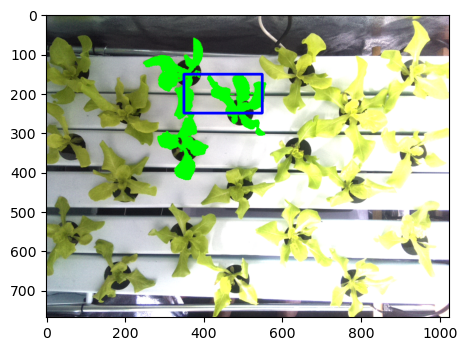

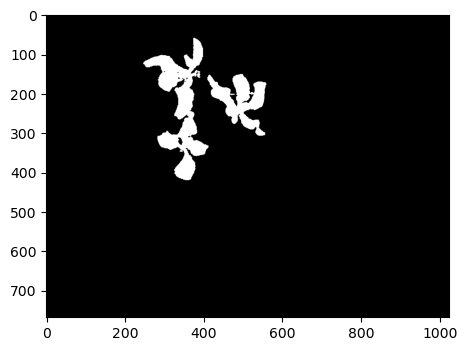

In [242]:
# Keep objects that overlap with the ROI

# Inputs:
#    img            = img to display kept objects
#    roi_contour    = contour of roi, output from any ROI function
#    roi_hierarchy  = contour of roi, output from any ROI function
#    object_contour = contours of objects, output from pcv.find_objects function
#    obj_hierarchy  = hierarchy of objects, output from pcv.find_objects function
#    roi_type       = 'partial' (default, for partially inside the ROI), 'cutto', or 
#                     'largest' (keep only largest contour)

roi_objects, roi_obj_hierarchy, kept_mask, obj_area = pcv.roi_objects(img=img1, roi_contour=roi_contour, 
                                                                      roi_hierarchy=roi_hierarchy,
                                                                      object_contour=id_objects, 
                                                                      obj_hierarchy=obj_hierarchy, 
                                                                      roi_type='partial')

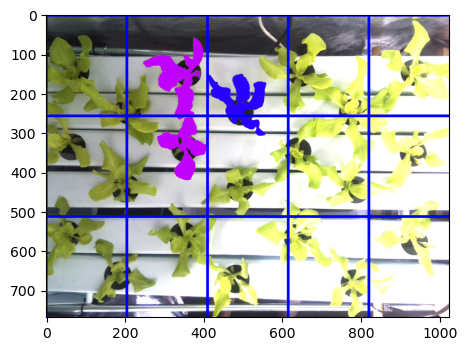

In [243]:
# This function take a image with multiple contours and
# clusters them based on user input of rows and columns

# Inputs:
#    img               = An RGB or grayscale image
#    roi_objects       = object contours in an image that are needed to be clustered.
#    roi_obj_hierarchy = object hierarchy
#    nrow              = number of rows to cluster (this should be the approximate  number of 
#                        desired rows in the entire image even if there isn't a literal row of plants)
#    ncol              = number of columns to cluster (this should be the approximate number of 
#                        desired columns in the entire image even if there isn't a literal row of plants)
#    show_grid         = if True then the grid is drawn on the image, default show_grid=False
clusters_i, contours, hierarchies = pcv.cluster_contours(img=img1, roi_objects=roi_objects, 
                                                         roi_obj_hierarchy=roi_obj_hierarchy, 
                                                         nrow=3, ncol=5, 
                                                         show_grid=True)


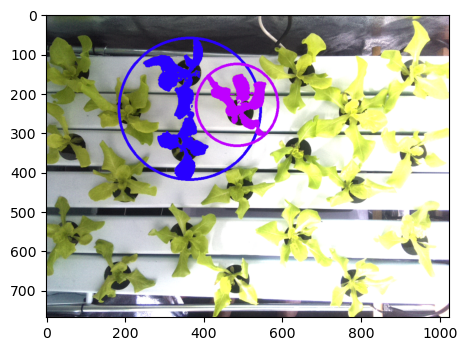

In [244]:
# Plot to visualize what pieces of plant got grouped together.

# Inputs:
#   img - RGB or grayscale image data for plotting
#   grouped_contour_indices - Indices for grouping contours
#   roi_objects - object contours in an image that are needed to be clustered.
#   roi_obj_hierarchy - object hierarchy
#   nrow - Optional, number of rows. If changed from default, grid gets plot. 
#   ncol - Optional, number of columns. If changed from default, grid gets plot. 
cluster_img = pcv.visualize.clustered_contours(img=img1, grouped_contour_indices=clusters_i, 
                                                roi_objects=contours,
                                                roi_obj_hierarchy=hierarchies)

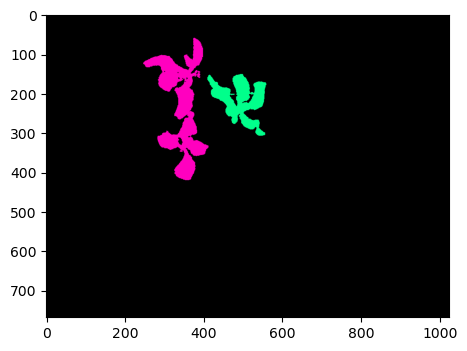

In [245]:
# Inputs:
# mask             = Mask/binary image to segment into clusters.
# algorithm        = Algorithm to use for segregating different clusters.
#                    Currently supporting OPTICS and DBSCAN. (Default="DBSCAN")
# min_cluster_size = The minimum size a section of a mask must be (in pixels)
#                    before it can be considered its own cluster. (Default=5)
# max_distance     = The total distance between two pixels for them to be considered a part
#                    of the same cluster.  For the DBSCAN algorithm, value must be between
#                    0 and 1.  For OPTICS, the value is in pixels and depends on the size
#                    of your picture.  (Default=0)
clust_img, clust_masks = pcv.spatial_clustering(mask=kept_mask, algorithm="DBSCAN", min_cluster_size=5, max_distance=None)



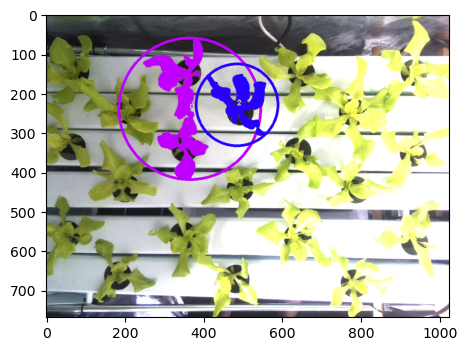

In [246]:
# Set the sequence of colors from the color_scale created by the 
# color_palette function to "sequential" or "random" order. 
# Default = "sequential". 
pcv.params.color_sequence = 'random'
cluster_img = pcv.visualize.clustered_contours(img=img1, grouped_contour_indices=clusters_i, 
                                                roi_objects=contours,
                                                roi_obj_hierarchy=hierarchies)

In [248]:
# This function takes clustered contours and splits them into multiple images,
# also does a check to make sure that the number of inputted filenames matches the number
# of clustered contours. If no filenames are given then the objects are just numbered

# Inputs:
#    img                     = ideally a masked RGB image.
#    grouped_contour_indexes = output of cluster_contours, indexes of clusters of contours
#    contours                = contours to cluster, output of cluster_contours
#    hierarchy               = object hierarchy
#    outdir                  = directory for output images
#    file                    = the name of the input image to use as a base name , output of filename from read_image function
#    filenames               = input txt file with list of filenames in order from top to bottom left to right (likely list of genotypes)

# Set global debug behavior to None (default), "print" (to file), or "plot" (Jupyter Notebooks or X11)
pcv.params.debug = "print"

out = args.outdir

# If you have a list of treatments, genotypes, etc. You would input a .txt file with them to help save
# the contours by names, add it to the options class and then add filenames=names to the 
# splitimg function below.  
output_path = pcv.cluster_contour_splitimg(rgb_img=img1, grouped_contour_indexes=clusters_i, contours=contours, 
                                           hierarchy=hierarchies, outdir=out, file=filename, filenames=None)

This function has been updated to include object hierarchy so object holes can be included


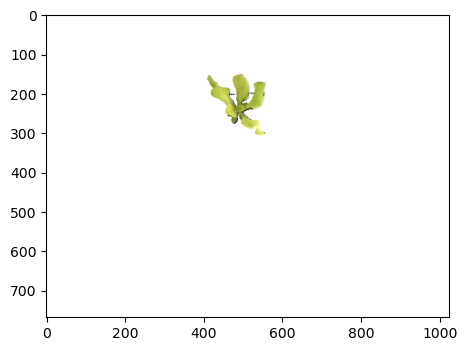

In [249]:
# Read in one of the isolated plant images 
pcv.params.debug = args.debug

single_plant, plant_path, plant_filename = pcv.readimage(filename='1865_clusters.png')